# Parte I: Análisis exploratorio

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from wordcloud import WordCloud
from gensim.models import KeyedVectors
from sklearn.preprocessing import normalize
from nltk.tokenize import TweetTokenizer
import re

# suprimir future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


SEED = 37
np.random.seed(SEED)
random.seed(SEED)
CUSTOM_PALLETE = ["#00A7E1", "#FFA630"]


In [4]:
train_path = 'data/train.csv'
df = pd.read_csv(train_path)
df.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
print('Shape:', df.shape)
df.describe()

Shape: (7613, 5)


,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [6]:
target_sum = df['target'].sum()
print(f"Cantidad de tweets \"Desastre\": {target_sum}")
print(f"Cantidad de tweets \"No Desastre\": {df['target'].count() - target_sum}")

Cantidad de tweets "Desastre": 3271
Cantidad de tweets "No Desastre": 4342


In [7]:
# Limpieza y preprocesamiento básico de texto
def clean_text(s):
    if pd.isna(s):
        return ''
    s = str(s)
    s = s.lower()
    s = re.sub(r'http\S+', ' ', s)
    s = re.sub(r'www\S+', ' ', s)
    s = re.sub(r'[^\w\s#@]', ' ', s)
    s = re.sub(r'[\s_]+', ' ', s).strip()
    return s

df['text_clean'] = df['text'].apply(clean_text)
df['keyword'] = df['keyword'].fillna('no_keyword_contained')
df['location'] = df['location'].fillna('no_location_contained')
df[['id','text','text_clean','keyword','location','target']].head()


,id,text,text_clean,keyword,location,target
0,1,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this #earthquake m...,no_keyword_contained,no_location_contained,1
1,4,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,no_keyword_contained,no_location_contained,1
2,5,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...,no_keyword_contained,no_location_contained,1
3,6,"13,000 people receive #wildfires evacuation or...",13 000 people receive #wildfires evacuation or...,no_keyword_contained,no_location_contained,1
4,7,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby #alaska as ...,no_keyword_contained,no_location_contained,1


In [88]:
df['text_len'] = df['text_clean'].apply(len)
df['word_count'] = df['text_clean'].apply(lambda s: len(s.split()))
df['mean_word_len'] = df.apply(lambda row: row['text_len'] / row['word_count'] if row['word_count'] > 0 else 0, axis=1)
df['num_hashtags'] = df['text'].apply(lambda s: 0 if pd.isna(s) else s.count('#'))
df['num_mentions'] = df['text'].apply(lambda s: 0 if pd.isna(s) else s.count('@'))
df['has_url'] = df['text'].apply(lambda s: 0 if pd.isna(s) else (1 if 'http' in s or 'www.' in s else 0))

disaster_terms = df['keyword'].dropna().unique().tolist()
def count_terms(s, terms=disaster_terms):
    s = s.lower()
    cnt = 0
    for t in terms:
        if t in s:
            cnt += 1
    return cnt
df['disaster_terms_count'] = df['text_clean'].apply(count_terms)

df[['text_len','word_count','mean_word_len','num_hashtags','num_mentions','has_url','disaster_terms_count']].describe().T


,count,mean,std,min,25%,50%,75%,max
text_len,7613.0,83.886904,31.963548,5.00,60.00,85.000000,109.0000,151.0
word_count,7613.0,14.664259,6.125010,1.00,10.00,15.000000,19.0000,34.0
mean_word_len,7613.0,5.879019,1.040318,2.75,5.16,5.777778,6.4375,13.5
num_hashtags,7613.0,0.446999,1.099841,0.00,0.00,0.000000,0.0000,13.0
num_mentions,7613.0,0.362406,0.720097,0.00,0.00,0.000000,1.0000,8.0
has_url,7613.0,0.521608,0.499566,0.00,0.00,1.000000,1.0000,1.0
disaster_terms_count,7613.0,1.374097,0.866296,0.00,1.00,1.000000,2.0000,7.0


## Visualizaciones

### 1. Distribución de longitudes del tweet según target

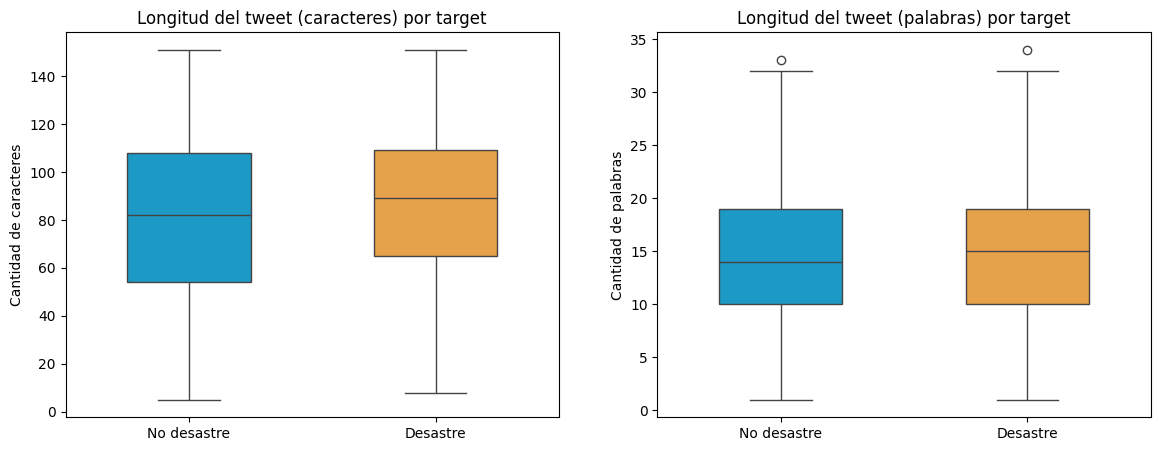

In [9]:
fig, axes = plt.subplots(1,2, figsize=(14,5))
sns.boxplot(x='target', y='text_len', data=df, palette=CUSTOM_PALLETE, width=0.5, ax=axes[0])
axes[0].set_title('Longitud del tweet (caracteres) por target')
axes[0].set_xlabel('')
axes[0].set_xticks([0,1], ['No desastre', 'Desastre'])
axes[0].set_ylabel('Cantidad de caracteres')

sns.boxplot(x='target', y='word_count', data=df, palette=CUSTOM_PALLETE, width=0.5, ax=axes[1])
axes[1].set_title('Longitud del tweet (palabras) por target')
axes[1].set_xlabel('')
axes[1].set_xticks([0,1], ['No desastre', 'Desastre'])
axes[1].set_ylabel('Cantidad de palabras')
plt.show()


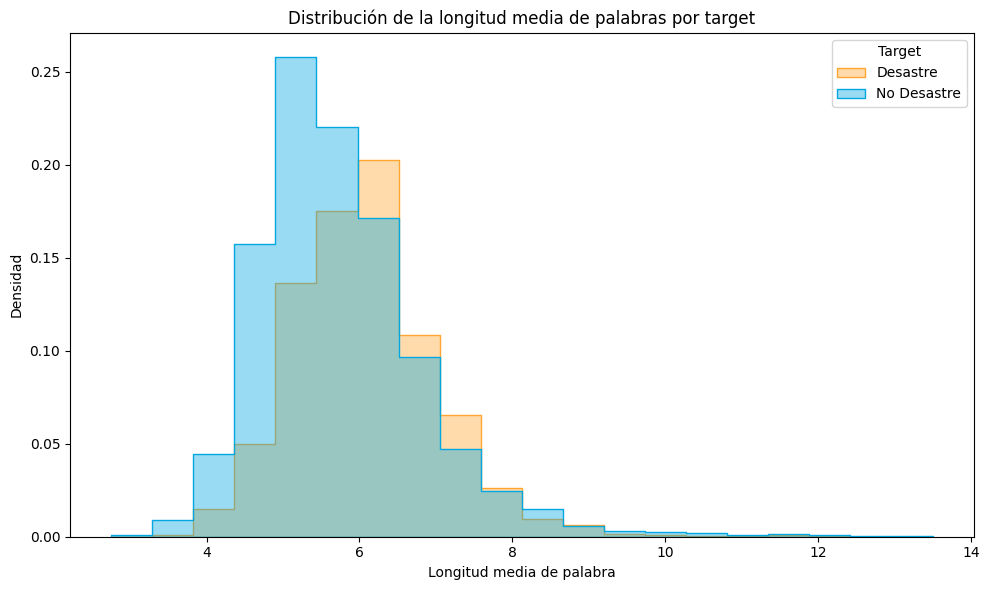

In [109]:
plt.figure(figsize=(10,6))
sns.histplot(
    data=df,
    x='mean_word_len',
    hue='target',
    bins=20,
    palette=CUSTOM_PALLETE,
    alpha=0.4,
    element='step',
    stat='density',
)
plt.title('Distribución de la longitud media de palabras por target')
plt.xlabel('Longitud media de palabra')
plt.ylabel('Densidad')
plt.legend(title='Target', labels=['Desastre', 'No Desastre'])
plt.tight_layout()
plt.show()

### 3. Proporción de tweets con URL / hashtags / mentions según target

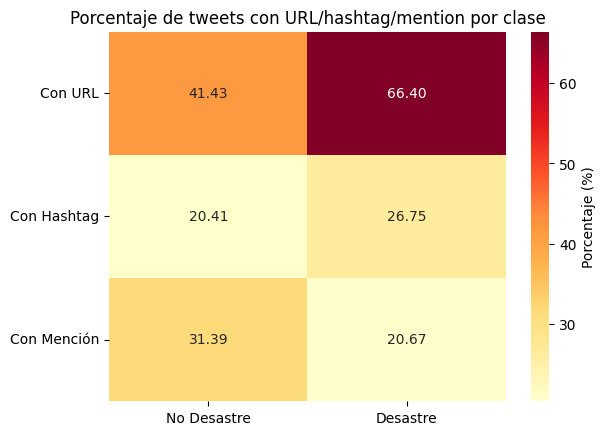

In [10]:
data = pd.DataFrame({
    'Con URL': df.groupby('target')['has_url'].mean()*100,
    'Con Hashtag': (df['num_hashtags']>0).groupby(df['target']).mean()*100,
    'Con Mención': (df['num_mentions']>0).groupby(df['target']).mean()*100
})
data = data.T
data.columns = ['No Desastre','Desastre']
sns.heatmap(data, annot=True, fmt=".2f", cmap='YlOrRd', cbar_kws={'label': 'Porcentaje (%)'})
plt.title('Porcentaje de tweets con URL/hashtag/mention por clase')
plt.yticks(rotation=0)
plt.show()


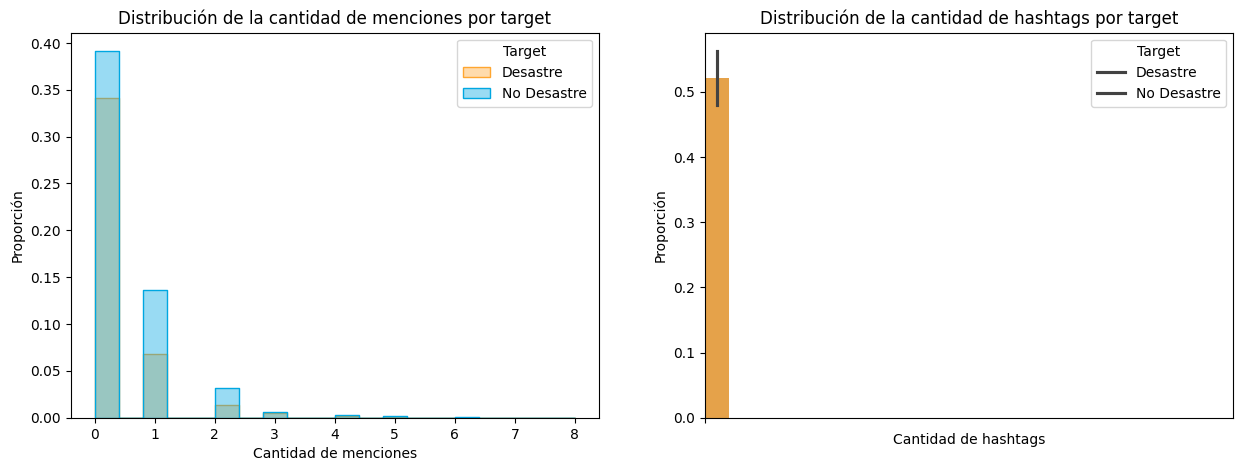

In [ ]:
count = df.groupby('target').agg({'num_mentions':'count', 'num_hashtags':'count'}).reset_index()
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5))

sns.histplot(
    data=df,
    x='num_mentions',
    hue='target',
    bins=20,
    palette=CUSTOM_PALLETE,
    alpha=0.4,
    stat='proportion',
    element='step',
    ax=ax[0],
)
ax[0].set_title('Distribución de la cantidad de menciones por target')
ax[0].set_xlabel('Cantidad de menciones')
ax[0].set_ylabel('Proporción')
ax[0].legend(title='Target', labels=['Desastre', 'No Desastre'])

sns.barplot(
    data=df,
    y='num_hashtags',
    hue='target',
    palette=CUSTOM_PALLETE,
    ax=ax[1],
)
ax[1].set_title('Distribución de la cantidad de hashtags por target')
ax[1].set_xlabel('Cantidad de hashtags')
ax[1].set_ylabel('Proporción')
ax[1].set_xlim(0, 8.5)
ax[1].legend(title='Target', labels=['Desastre', 'No Desastre'])

plt.show()

### 4. Cantidad de tweets según cantidad de términos relacionados a desastres por target

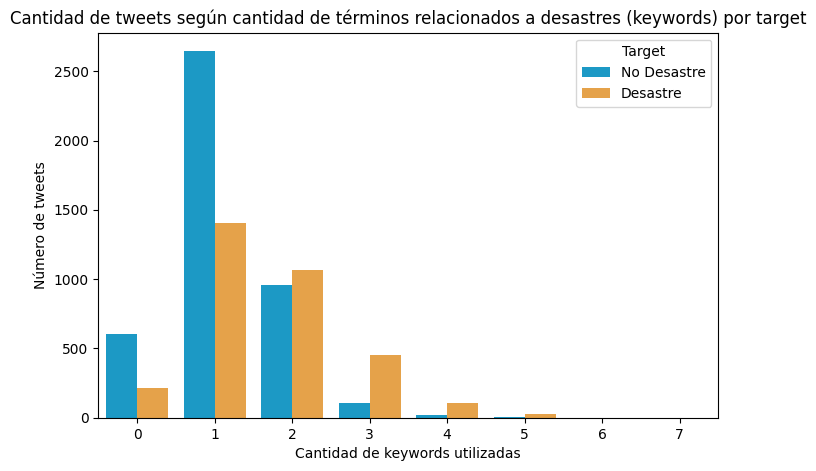

In [11]:
plt.figure(figsize=(8,5))
data = df.groupby(['disaster_terms_count','target']).size().reset_index(name='count')
data['target'] = data['target'].apply(lambda x: "No Desastre" if x == 0 else "Desastre")
sns.barplot(hue='target', x='disaster_terms_count', y='count', data=data, palette=CUSTOM_PALLETE)
plt.title('Cantidad de tweets según cantidad de términos relacionados a desastres (keywords) por target')
plt.xlabel('Cantidad de keywords utilizadas')
plt.ylabel('Número de tweets')
plt.legend(title="Target")
plt.show()

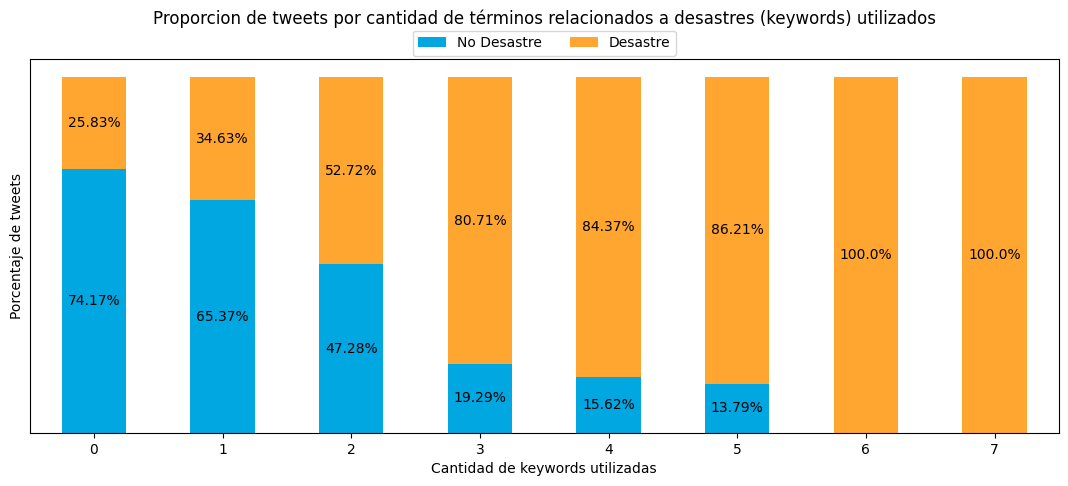

In [12]:
data = df.groupby(['disaster_terms_count','target'])["id"].nunique().unstack()
data.columns = ['No Desastre','Desastre']
data.fillna(0, inplace=True)
fig, ax = plt.subplots(figsize=(12,6))
data.div(data.sum(axis=1), axis=0)\
    .plot(kind='bar', stacked=True, figsize=(12,6), color=CUSTOM_PALLETE, ax=ax)

for c in ax.containers:
    labels = [str(round(v.get_height()*100, 2)) + "%" if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c,
                 label_type='center',
                 labels = labels,
                 size = 10)
    
plt.title('Proporcion de tweets por cantidad de términos relacionados a desastres (keywords) utilizados', pad=25)
plt.tight_layout(pad=5)
plt.legend(ncols=2, loc='upper center', bbox_to_anchor=(0.5, 1.095))
plt.xlabel('Cantidad de keywords utilizadas')
plt.ylabel('Porcentaje de tweets')
plt.yticks(ticks=[])
plt.xticks(rotation=0)
plt.show()

### 5. Top 10 keywords según target

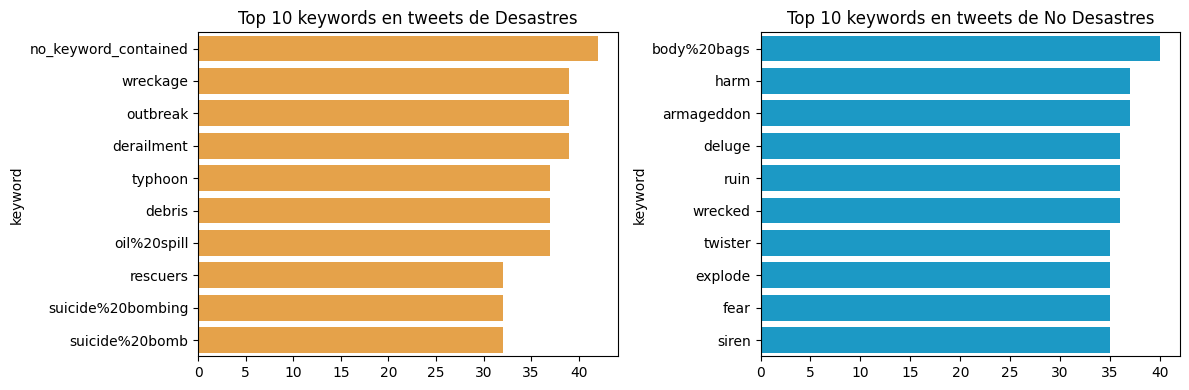

In [13]:
topK = 10
kw_pos = df[df['target']==1]['keyword'].value_counts().head(topK)
kw_neg = df[df['target']==0]['keyword'].value_counts().head(topK)
fig, axes = plt.subplots(1,2, figsize=(12, 4))
sns.barplot(x=kw_pos.values, y=kw_pos.index, ax=axes[0], color=CUSTOM_PALLETE[1])
axes[0].set_title(f'Top {topK} keywords en tweets de Desastres')
sns.barplot(x=kw_neg.values, y=kw_neg.index, ax=axes[1], color=CUSTOM_PALLETE[0])
axes[1].set_title(f'Top {topK} keywords en tweets de No Desastres')
plt.tight_layout()
plt.show()


#### 6. Nubes de palabras para cada target

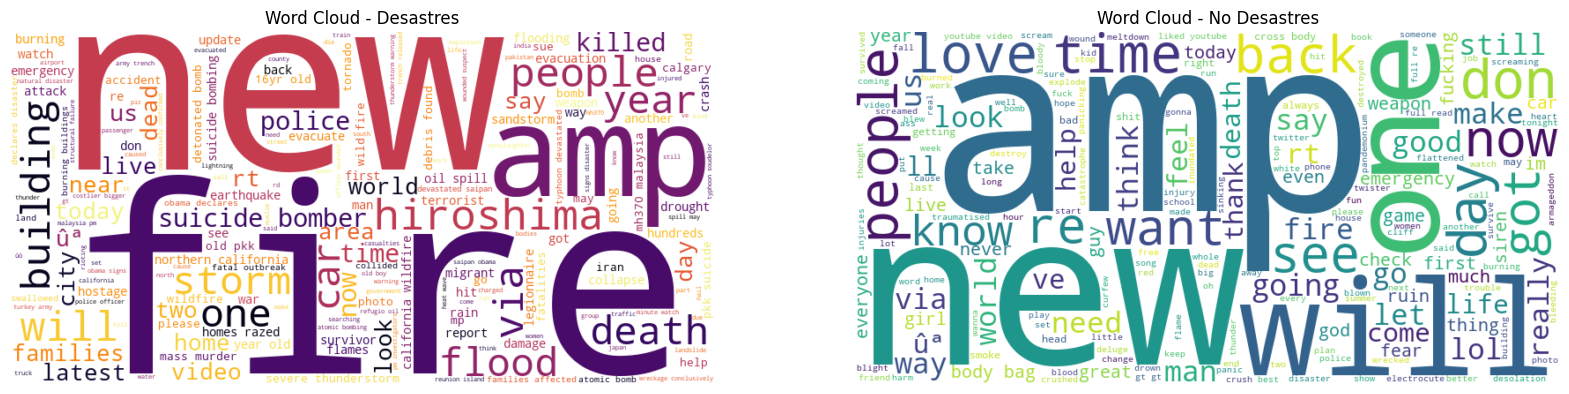

In [14]:
def generate_word_cloud(colormap, words):
    return WordCloud(
        width=800, height=400, background_color='white', random_state=SEED*2,
        min_word_length=2 ,colormap=colormap
    ).generate(words)
    
disaster_words = ' '.join(df[df['target']==1]['text_clean'].tolist())
not_disaster_words = ' '.join(df[df['target']==0]['text_clean'].tolist())
disaster_wc = generate_word_cloud("inferno", disaster_words)
not_disaster_wc = generate_word_cloud("viridis", not_disaster_words)
fig, axes = plt.subplots(1,2, figsize=(20,8))
axes[0].imshow(disaster_wc, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Word Cloud - Desastres')
axes[1].imshow(not_disaster_wc, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Word Cloud - No Desastres')
plt.show()


### Análisis de palabras importantes usando TF-IDF + RandomForest
Entreno un RandomForest rápido sobre TF-IDF para extraer las palabras más importantes según el modelo. 
Esto es sólo para realizar un análisis exploratorio, no es el baseline.

F1 (val): 0.7380560131795717


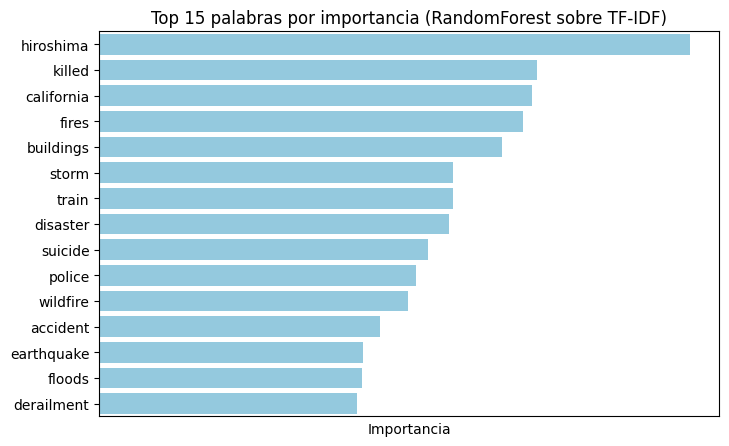

In [50]:
y = df['target'].values
X_train, X_val, y_train, y_val = train_test_split(df['text_clean'], y, test_size=0.2, random_state=SEED)
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english')
vectorizer.fit(X_train)
X_tfidf = vectorizer.transform(X_train)

rf = RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1)
rf.fit(X_tfidf, y_train)
val_tfidf = vectorizer.transform(X_val)
y_pred = rf.predict(val_tfidf)
print('F1 (val):', f1_score(y_val, y_pred))

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:15]
feat_names = np.array(vectorizer.get_feature_names_out())
top_words = feat_names[indices]
top_importances = importances[indices]

plt.figure(figsize=(8,5))
sns.barplot(x=top_importances, y=top_words, color='skyblue')
plt.title('Top 15 palabras por importancia (RandomForest sobre TF-IDF)')
plt.xlabel('Importancia')
plt.xticks(ticks=[])
plt.show()


In [83]:
tsne = TSNE(n_components=2, random_state=SEED, perplexity=40)
X_embedded = tsne.fit_transform(X_tfidf.toarray())


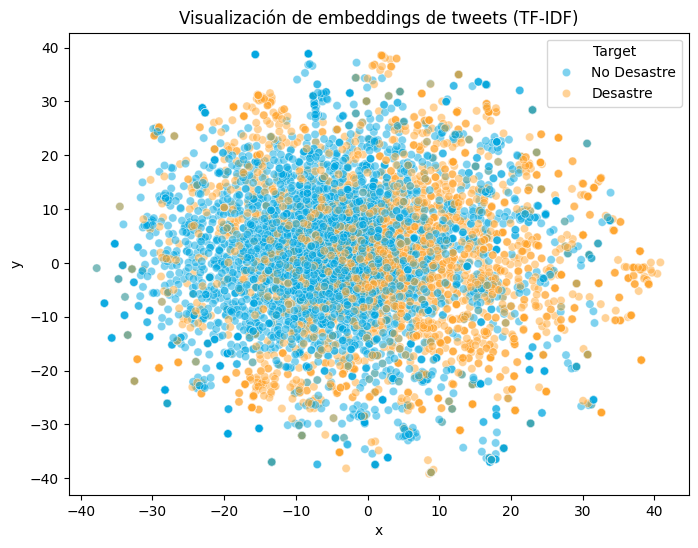

In [86]:
df_plot = pd.DataFrame({
    'x': X_embedded[:,0],
    'y': X_embedded[:,1],
    'target': ['Desastre' if t == 1 else 'No Desastre' for t in y_train]
})
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_plot,
    x='x',
    y='y',
    hue='target',
    palette=CUSTOM_PALLETE,
    alpha=0.5
)
plt.title("Visualización de embeddings de tweets (TF-IDF)")
plt.legend(title='Target')
plt.show()

In [ ]:
w2v_path = "GoogleNews-vectors-negative300.bin"
w2v = KeyedVectors.load_word2vec_format(w2v_path, binary=True)

In [59]:
def tokenize(text):
    tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
    return tknzr.tokenize(text)


def sentence_vector_avg(tokens, model, dim):
    if not tokens:
        return np.zeros(dim, dtype=float)
    vecs = []
    for w in tokens:
        if w in model:
            vecs.append(model[w])
        elif w.lower() in model:
            vecs.append(model[w.lower()])
    if len(vecs) == 0:
        return np.zeros(dim, dtype=float)
    return np.mean(vecs, axis=0)

texts = df['text_clean'].astype(str).tolist()
tokens_list = [tokenize(t) for t in texts]

vecs = []
labels = []
for i in range(len(tokens_list)):
    tokens = tokens_list[i]
    v = sentence_vector_avg(tokens, w2v, dim=w2v.vector_size)
    vecs.append(v)
    labels.append(int(df.iloc[i]['target']))

X = np.vstack(vecs)
X_norm = normalize(X, norm='l1')
tsne = TSNE(n_components=2, random_state=SEED, perplexity=40)
X_2d = tsne.fit_transform(X_norm)

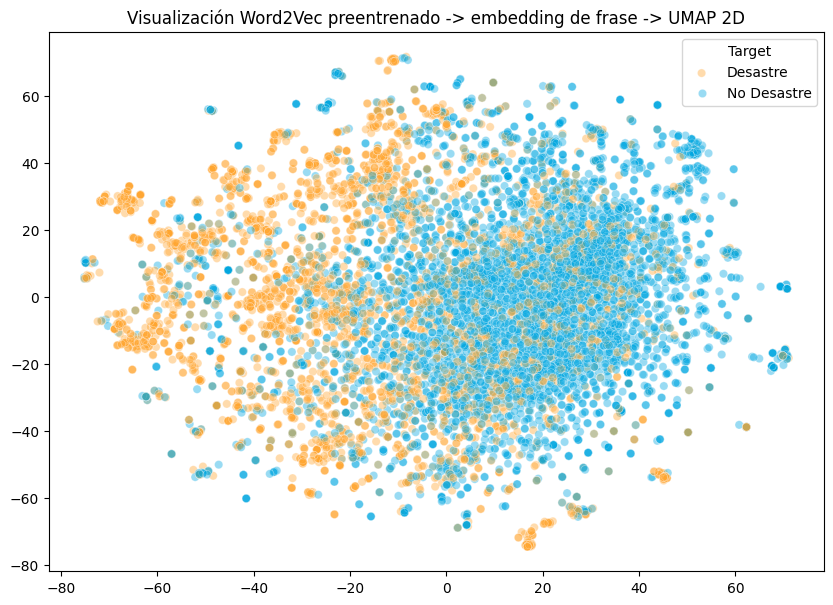

In [ ]:
plt.figure(figsize=(10,7))
sns.scatterplot(
    x=X_2d[:,0],
    y=X_2d[:,1],
    hue=labels,
    palette=CUSTOM_PALLETE,
    alpha=0.4
)
plt.title('Visualización Word2Vec preentrenado (GoogleNews-vectors-negative300)')
plt.legend(title='Target', labels=['Desastre', 'No Desastre'])
plt.show()
